# <span id="chap_concepts_geometry"></span> Networks and geometry

One of the most obvioous things to do with a network is draw it, putting the nodes and edges down on paper (or on a screen) so that we can see what's going on. This process of **network (or graph) drawing** is a key part of network science, and comes from the large body of knowledge known as **scientific visualisation** whereby we try to present scientific data and results in a way that makes them most easily interpreted by the audience we're targeting. Sometimes we're looking for visualisations that appeal to non-specialists; sometimes we want to highlight arcane points that only an expert will understand; but in either case we need to think carefully about the way we present the information we want to show.

Graph drawing has a huge literature, with its own [web site](http://www.graphdrawing.org/). See di Battista *et alia* [[dBET96]](#dBET94) for an older but still relevant guide. We'll not even scratch the surface in this chapter, but we'll look at some different ways of presenting different kinds of networks, using `networkx` to generate diagrams. We'll see that, often, these sorts of visualisations aren't as useful as we might like in making serious scientific points, and later we'll see a lot more presentations that bring out details more appropriately.

## <span is="sec_concepts_geometry_topology_geometry"></span> Topology <i>vs.</i> geometry

Drawing a network implies that we decide where on the page or screen to draw each element. In some cases there is a natural notion of how to do this: some networks have a natural notion of "what shape they are". The lattices we looked at [earlier](concepts-networks.ipynb#sec_concepts_networks_lattice) are a case in point: we have a clear idea of what a lattice "should" look like &ndash; and if we're looking at something that we *know* to be a lattice, we'll find it strange if it is drawn in any other way.

By contrast, there are other networks that *don't* have a natural notion of shape. A social network is a good example,  where the nodes represent people and the edges represent friendship links. What is the shape of such a network? There doesn't seem to be any natural answer to this question.

We saw [earlier](concepts-networks.ipynb#sec_concepts_networks_lattice) that all networks have notions of adjacency and neighbourhood, of what nodes are "connected to" which other nodes. [Later](concepts-paths.ipynb) we'll see that there are many other notions that build on these simple ideas of distance between nodes. But this implies that we *always* have a notion of closeness &ndash; but we *don't always* have a notion of position.

We can make this more precise by saying that all networks have a **topology**. Toplogy is the study of shape, and the ways in which features are changed or preserved as the shape changes. Topology actually lies at the heart of much of modern mathematics, and is a fascinating study in and of itself &ndash; but one that quickly transcends what we need for complex networks, where we mainly need notions of neighbourhood and connectivity. Network topology is a major factor influencing how processes operate and can be controlled.

For drawing a network, though, we're interested in notions of **geometry**: where nodes are positioned on a page or screen. While *all* networks have a topology, only *some* networks have a natural geometry. In drawing a network we will generally either **respect** the natural geometry of the network (if it has one), or **impose** a geometry onto the network for the purposes of drawing it. That isn't to say we must always draw networks in only one way: there are often very good reasons for choosing other presentations, in order to make well-defined points about the network or a process over it. The important point is that we make the choice of geometry deliberately with a view to showing what we want to show.

### <span id="sec_concepts_geometry_ignoring"></span> When we ignore intrinsic geometry

We can use the lattice to show what happens when we ignore the intrinsic geometry of a network that has one.

In [1]:
import networkx
import numpy

import cncp

import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn

/Users/sd/research/writing/complex-networks-complex-processes/notebook/cncp/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Let's first create a small lattice:  

In [2]:
mesh = cncp.lattice_graph(10, 10)

What does the network look like? We can use `networkx` to visualise it, turning off the node labels since they're not really very important to what we're trying to show:

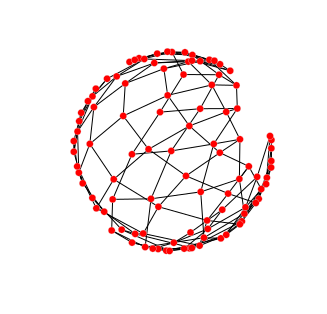

In [3]:
fig = plt.figure(figsize = (5, 5))
plt.gca().set_axis_off()

networkx.draw_networkx(mesh, with_labels = False, node_size = 50)

_ = plt.show()

It's kind of lattice-y, I suppose, but it doesn't really look much like a lattice as we usually imagine them &ndash; like a chessboard. What's happened is the `networkx` has created a geometry from the underlying topology using a default algorithm, and what it's come up with doesn't match our intuitions. (That isn't to say the geometry is *wrong*, simply that we'd prefer to see it differently.)

The process of generating a geometry is called a **layout**, usually performed by a **layout algorithm** (although it can also be done by hand, by specifying the positions of nodes manually. Generally speaking a layout algorithm just positions the nodes, with the edges then connecting them. The layout is then passed to `networkx`'s drawing function `draw_network()` which draws the nodes at the specified places.

### <span id="sec_concepts_geometry_lattice_layout"></span> Defining a layout

What do we do about a "poor" layout? We could simply accept it, but that doesn't really help getting to grips with things, since we're looking at something that doesn't reflect our intuition. That makes it hard to then use our intuitions to interpret features in the network. It's far better to spend a little extra time so that how we *think* about lattices is how we *present* them: this will help foster understanding.

Therefore we'll code-up our own layout algorithm, which means defining a function that maps nodes to co-ordinates. We'll actually do slightly more than this: we'll define a layout function that arranges the nodes in a grid, and then wrap this in a helper function we can call when we need it:

In [4]:
def lattice_positions( lattice, lattice_rows, lattice_columns ):
    """Return a dictionary of positions for nodes laid out in a lattice.
    
    :param lattice: the lattice
    :param lattice_rows: the number of rows in the lattice
    :param lattice_cols: the nmumber of columns in the lattice
    :returns: a dict of positions"""

    pos = dict()
    rh = 1.0 / (lattice_rows)           # row height
    cw = 1.0 / (lattice_columns)        # column width
    
    # run through the rows and columns, laying-out nodes as we go
    # and storing their co-ordinates into pos. Co-ordinates lie in
    # the range [0.0 ... 1.0]
    nodes = lattice.nodes_iter()
    try:
        for r in xrange(lattice_rows):
            for c in xrange(lattice_columns):
                n = nodes.next()
                pos[n] = (c * cw,
                          1.0 - r * rh) # lowest nodes in the top row, not the bottom
    except StopIteration:
        # ran out of nodes, so drop through
        pass
    
    return pos

def draw_lattice( lattice, lattice_rows = None, lattice_columns = None, **kwds ):
    """Draw the network with a lattice layout.
    
    :param lattice: the network to position
    :param lattice_rows: the number of rows in the lattice
    :param lattice_columns: the number of columns in the lattice
    """
    
    # fill in the argument defaults where not specified
    if lattice_rows is not None:
        if lattice_columns is None:
            # rows fixed, set the columns
            lattice_columns = g.order() / lattice_rows
            if lattice.order() % lattice_rows > 0:
                lattice_columns = lattice_columns + 1
    else:
        if lattice_columns is None:
            # neither rows nor columns fixed, set both
            lattice_rows = lattice_columns = int(numpy.sqrt(lattice.order()))
            if lattice_rows * lattice_columns < lattice.order():
                lattice_rows = lattice_rows + 1
        else:
            # columns fixed, set the rows
            lattice_rows = lattice.order() / lattice_columns
            if lattice.order() % lattice_columns > 0:
                lattice_rows = lattice_rows + 1

    # compute the layout using these dimensions
    pos = lattice_positions(lattice, lattice_rows, lattice_columns)
    
    # pass through the layout and any additional keyword arguments
    return networkx.draw_networkx(lattice, pos, **kwds)

This is perhaps a bit hardcore at this stage, but it illustrates approaches we'll use later. `matplotlib` plots diagrams using co-ordinates on the range $[0.0, 1.0]$ on both axes. The `lattice_positions` function simply divides this range evenly according to the numbers of rows and columns we want.  The `draw_lattice` function provides some useful defaults for deciding these dimensions: you can fix the number of rows and columns, either of them, or neither, and the function will pick default values itself. But `draw_lattice()` is basically just a wrapper around the usual `draw_network()` function, that uses a lattice layout and accepts all the same optional arguments as `draw_network()` does (of which more later). 

We can then plot the lattice we created earlier using this function:

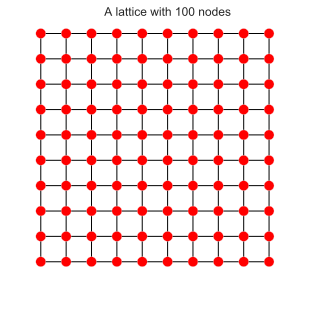

In [5]:
# set up a figure with a little tidying-up 
fig = plt.figure(figsize = (5, 5))
plt.gca().set_axis_off()             # axes off
plt.gca().set_xlim([-0.05, 1.05])    # add a little space around the plot
plt.gca().set_ylim([-0.05, 1.05])
plt.title("A lattice with {n} nodes".format(n = mesh.order()))

# draw the lattice
draw_lattice(mesh, with_labels = False, node_size = 100)

_ = plt.show()

That's much more intuitive. To re-iterate, the geometry of the network is something we impose upon it by deciding where to place nodes in a diagram. There's nothing intrinsic about it, and we can impose lots of different geometric layouts on the same network. Its the topology of the network &ndash; the ways in which nodes are connected by edges &ndash; that is an intrinsic property of the network: perhaps the most important intrinsic property, and one that we can explore in some detail to get a better understanbding of the sorts of networks we can encounter when modelling different phenomena.

## <span id="sec_concepts_geometry_layouts"></span> Automated layouts

How did `networkx` create the default layout above? `networkx` actually has several layout algorithms, each presented as a drawing function exactly like our `draw)lattice()` above that wraps-up a corresponding layout function. In a recent version of `networkx` there were five different layouts:

* random: place nodes uniformly at random in the diagram
* circular: position nodes around the edge of a circle
* shell: position nodes in concentric circles
* spring: position nodes using a ["force-directed" layout](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) that tries to minimise edge crossings
* spectral: positions nodes using the structure of the eigenvectors

By default `networkx` uses the spring layout.

The circular and random layouts probably need no more explanation, but we can see what sort of layout they produce when applied to the lattice:

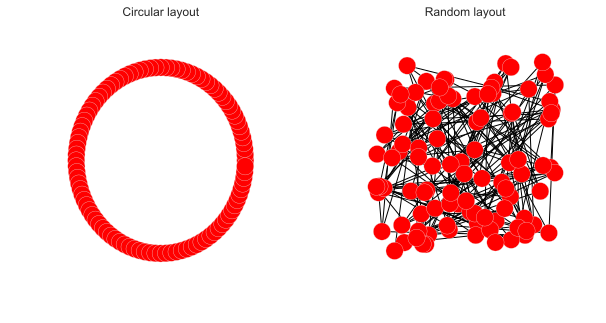

In [6]:
fig = plt.figure(figsize = (10, 5))
plt.gca().set_axis_off() 
plt.gca().set_xlim([-0.05, 1.05])
plt.gca().set_ylim([-0.05, 1.05])

plt.subplot(1, 2, 1)
networkx.draw_circular(mesh)
plt.title('Circular layout')

plt.subplot(1, 2, 2)
networkx.draw_random(mesh)
plt.title('Random layout')

_ = plt.show()

The force-directed layout we have already seen. It starts with a random layout and then refines it progressively to balance the layout. There are parameters to specify the number of itrerations this refinement goes through, and in principle more iterations will lead to a "better" layout:

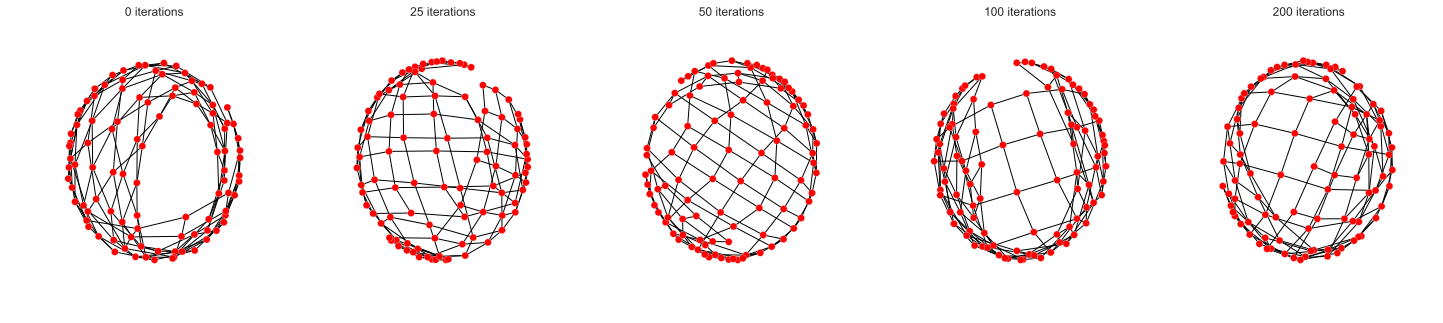

In [19]:
fig = plt.figure(figsize = (25, 5))
plt.gca().set_axis_off() 
plt.gca().set_xlim([-0.05, 1.05])
plt.gca().set_ylim([-0.05, 1.05])

iterations = [ 0, 25, 50, 100, 200 ]
for i in range(len(iterations)):
    ax = plt.subplot(1, len(iterations), i + 1)
    ax.set_axis_off() 
    networkx.draw_spring(mesh, node_size = 50, iterations = iterations[i])
    plt.title('{its} iterations'.format(its = iterations[i]))

_ = plt.show()

The final layout is perhaps more regular, reflecting the regularity of the underlying lattice &ndash; but it's hardly a "good" layout for this sort of network. However, for networks without an intrinsic geometry, the spring layout often generates an aesthetically pleasing arrangement. Whether this is a good criterion for a particular drawing is a matter we'll discuss [below](#sec_concepts_geometry_limitations).

The shell layout is an interesting one. It lets the designer select sub-sets of nodes to position in concentric circles.  In that sense it's less automatic than the other layouts, but it has the critical advantage that we can use it to bring out certain features of the network that we might want to highlight.

To show this, let's [get ahead of ourselves slightly](concepts-paths.ipynb) and study the distances of nodes from one particular node. We choose a node &ndash; for example the top-left corner &ndash; and work out the distance from this node to every other node in the network. We then place the nodes at different distances into different shells of the layout, and use the shell layout to show them. For clarity we'll also add some colour to show which nodes land where:

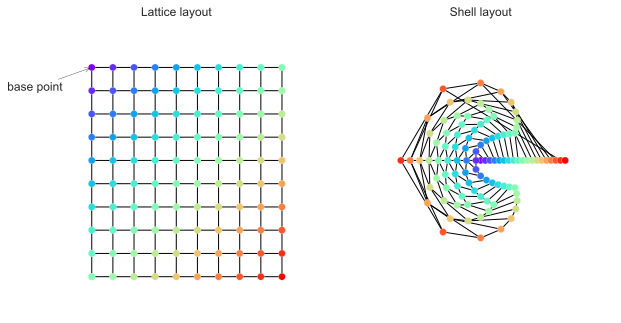

In [46]:
# work out the distances
dist = []                      # distance of each node from the base point
atDistance = dict()            # nodes at a given distance from the base point
base = 0
for n in mesh.nodes_iter():
    d = len(networkx.shortest_path(mesh, base, n)) - 1
    dist.append(d)
    if d not in atDistance.keys():
        atDistance[d] = []
    atDistance[d].append(n)

# convert the dict of distances from the base point to a list of lists,
# to construct the shells of the shell layout
shells = []
diameter = max(dist)           # the largest shortest path
for i in range(diameter + 1):
    shells.append(atDistance[i])

fig = plt.figure(figsize = (10, 5))
plt.gca().set_axis_off() 
plt.gca().set_xlim([-0.05, 1.05])
plt.gca().set_ylim([-0.05, 1.05])

colour_map = plt.cm.rainbow    # the colours we're going to use as highlights

ax1 = plt.subplot(1, 2, 1)
ax1.set_axis_off() 
draw_lattice(mesh, node_color = dist, cmap = colour_map, vmin = 0, vmax = diameter,
             with_labels = False, node_size = 50)
plt.title('Lattice layout')

# highlight the base point, just for clarity
ax1.annotate("base point",
            xy = (0.0, 1.0), xycoords = 'data',
            xytext = (-0.4, 0.9), textcoords = 'data',
            arrowprops = dict(arrowstyle = "->",
                              ec = 'k',
                             ),
            )

ax2 = plt.subplot(1, 2, 2)
ax2.set_axis_off() 
networkx.draw_networkx(mesh, pos = networkx.shell_layout(mesh, shells),
                       node_color = dist, cmap = colour_map, vmin = 0, vmax = diameter,
                       with_labels = False, node_size = 50)
plt.title('Shell layout')

_ = plt.show()

You can see how the farther-away nodes (coloured red in the lattice layout on the left) have landed farthest from the base point in the shell layout on the right.

## <span id="sec_concepts_geometry_limitations"></span> The limitations of drawing networks

The examples above illustrate both the power and the drawbacks of network drawing, even on so small a network. It's possible to *use* the fact that we have a choice of geometries for a network, to try to highlight key features. The human visual system is highly optimised to spotting patterns, and the basis of graph drawing (and any other klind of scientific visualisation) is to use this to help understand complex data.

Set against this, it's clear that simply drawing a network conveys very little information unless the presentation has been crafted for a purpose. Once you understand the shell layout, for example, you can see the increasing distance and even the relative numbers of nodes at different distances &ndash; but you can probably do the same just as easily (or easier) from the coloured lattice. And it's easy to imagine that drawing a sizeable network with thousands of ndoes would obscure rather than reveal the core features.

For this reason, network science often relies on visualisations other that graph drawing: traditional line graphs and histograms, for example, that make the metrics and numbers we're interested in stand out.

## References

<a id="dBET94">[dBET94]</a> Giuseppe di Battista, Peter Eades, Roberto Tamassia and Ioannis Tollis. <a href="http://www.graphdrawing.org/literature/gdbiblio.pdf">Algorithms for drawing graphs: an annotated bibliography</a>. 1994.